In [1]:
# ===========================================
# 0) Kurulum ve log/uyarı ayarları (temizlik)
# ===========================================
import os, warnings, logging
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.filterwarnings("ignore")
logging.getLogger().setLevel(logging.ERROR)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             precision_recall_curve, roc_curve,
                             classification_report)

from minisom import MiniSom
from sklearn.cluster import KMeans


In [2]:
# ===========================================
# 1) Veri: Yükle, hedef/özellik ayır, kimlik kolonu at
# ===========================================
# NEDEN? 'CustomerID' gibi kimlik kolonları davranış bilgisi içermez, uzaklık tabanlı yöntemleri bozar.
#       Bu yüzden mutlaka çıkarıyoruz.

CSV_PATH = "Credit_Card_Applications.csv"   # gerekirse değiştir
df = pd.read_csv(CSV_PATH)
print("Şekil:", df.shape)
print(df.head(3))

assert "Class" in df.columns, "Class etiketi bulunamadı"

drop_cols = []
for cand in ["CustomerID", "customer_id", "ID", "id"]:
    if cand in df.columns:
        drop_cols.append(cand)

y = df["Class"].values.astype(int)
X = df.drop(columns=["Class"] + drop_cols)

print("\nKullanılan özellik sayısı:", X.shape[1])


Şekil: (690, 16)
   CustomerID  A1     A2     A3  A4  A5  A6     A7  A8  A9  A10  A11  A12  \
0    15776156   1  22.08  11.46   2   4   4  1.585   0   0    0    1    2   
1    15739548   0  22.67   7.00   2   8   4  0.165   0   0    0    0    2   
2    15662854   0  29.58   1.75   1   4   4  1.250   0   0    0    1    2   

   A13   A14  Class  
0  100  1213      0  
1  160     1      0  
2  280     1      0  

Kullanılan özellik sayısı: 14


In [3]:
# ===========================================
# 2) Ölçekleme (StandardScaler)
# ===========================================
# NEDEN? SOM öklid mesafesi kullanır; ölçek farkları sonucu bozar.
#       Tüm sayısal sütunları standardize ediyoruz (mean=0, std=1).
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test böl (etiket sadece değerlendirme için)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

print("Split:", X_train.shape, X_test.shape,
      " | train fraud rate:", y_train.mean(), " | test fraud rate:", y_test.mean())


Split: (552, 14) (138, 14)  | train fraud rate: 0.44565217391304346  | test fraud rate: 0.4420289855072464


In [4]:
# ===========================================
# 3) SOM Eğitimi
# ===========================================
# Grid boyutunu veri büyüklüğüne göre "sıkı" tutuyoruz (12x12 / 15x15 iyi başlar).
# Sigma: Komşuluk genişliği (1.5-2.0 arası genelde iyi)
# Learning rate: 0.5 ile başla, MiniSom iterasyonla düşürür.
m, n = 12, 12
sigma = 1.8
lr = 0.5
iterations = 15 * X_train.shape[0]  # 10-20x N_train iyi pratik; hızlı test için 5x seçilebilir

som = MiniSom(x=m, y=n, input_len=X_train.shape[1], sigma=sigma, learning_rate=lr,
              neighborhood_function='gaussian', random_seed=42)
som.random_weights_init(X_train)
print("SOM init tamam.")

som.train_random(X_train, iterations, verbose=True)
print("SOM eğitim bitti.")


SOM init tamam.
 [ 8280 / 8280 ] 100% - 0:00:00 left 
 quantization error: 1.7493587962983654
SOM eğitim bitti.


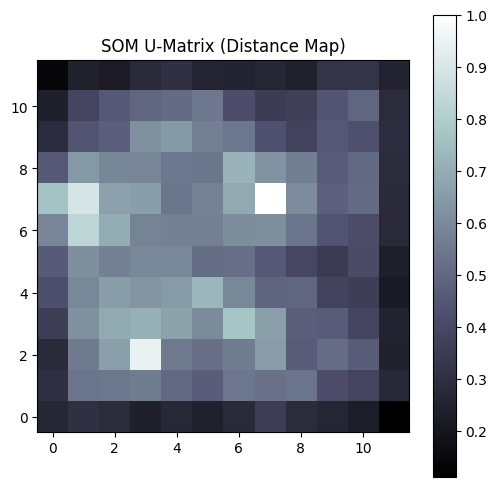

In [5]:
# ===========================================
# 4) U-Matrix (Distance Map) Görselleştirme
# ===========================================
# NEDEN? Hücreler arası mesafe ısı haritası; yüksek mesafeli bölgeler sınır/anomali adacıkları olabilir.
u_matrix = som.distance_map()  # (m, n)

plt.figure(figsize=(6,6))
plt.imshow(u_matrix.T, cmap="bone", origin="lower")
plt.title("SOM U-Matrix (Distance Map)")
plt.colorbar()
plt.show()


In [6]:
# ===========================================
# 5) Skor-1: Quantization Error (QE) tabanlı anomaly score
# ===========================================
# NEDEN? Her örneğin en iyi eşleşen hücre (BMU) ağırlığına uzaklığı = "ne kadar uymuyor" = anomali skoru
def som_quantization_error(som, x):
    w = som.get_weights()       # (m, n, d)
    bmu = som.winner(x)         # (i, j)
    w_bmu = w[bmu]              # (d,)
    return np.linalg.norm(x - w_bmu)

scores_qe = np.array([som_quantization_error(som, x) for x in X_test])

roc_qe = roc_auc_score(y_test, scores_qe)
pr_qe  = average_precision_score(y_test, scores_qe)
print(f"[QE] ROC-AUC: {roc_qe:.4f} | PR-AUC: {pr_qe:.4f}")


[QE] ROC-AUC: 0.5906 | PR-AUC: 0.5312


In [7]:
# ===========================================
# 6) Skor-2: BMU "fraud yoğunluğu" (semi-supervised propensity)
# ===========================================
# NEDEN? Unsupervised SOM üzerinde, sadece skor fonksiyonunu etiketle kalibre ediyoruz:
#       Her BMU hücresi için train set fraud oranını hesapla; testte o hücreye düşenlere bu oranı skor olarak ver.
from collections import defaultdict

bmu_train = np.array([som.winner(x) for x in X_train])

cell_counts = defaultdict(int)
cell_fraud  = defaultdict(int)
for (cx, cy), lab in zip(bmu_train, y_train):
    cell_counts[(cx, cy)] += 1
    cell_fraud[(cx, cy)]  += int(lab)

cell_rate = {k: (cell_fraud[k] / cell_counts[k]) for k in cell_counts.keys()}

bmu_test = np.array([som.winner(x) for x in X_test])
scores_prop = np.array([cell_rate.get(tuple(c), 0.0) for c in bmu_test])

roc_prop = roc_auc_score(y_test, scores_prop)
pr_prop  = average_precision_score(y_test, scores_prop)
print(f"[BMU-Propensity] ROC-AUC: {roc_prop:.4f} | PR-AUC: {pr_prop:.4f}")


[BMU-Propensity] ROC-AUC: 0.8815 | PR-AUC: 0.8464


In [8]:
# ===========================================
# 7) Skorları birleştirme (opsiyonel basit ortalama)
# ===========================================
# NEDEN? QE ve Propensity farklı sinyaller taşır; basit bir ensemble çoğu zaman daha iyi sonuç verir.
scores_combo = 0.5 * ( (scores_qe - scores_qe.min()) / (scores_qe.ptp()+1e-12) ) + \
               0.5 * ( (scores_prop - scores_prop.min()) / (scores_prop.ptp()+1e-12) )

roc_combo = roc_auc_score(y_test, scores_combo)
pr_combo  = average_precision_score(y_test, scores_combo)
print(f"[COMBO] ROC-AUC: {roc_combo:.4f} | PR-AUC: {pr_combo:.4f}")


[COMBO] ROC-AUC: 0.8972 | PR-AUC: 0.8947


In [9]:
# ===========================================
# 8) Eşik seçimi: PR eğrisinden (F1-opt veya Precision>=x)
# ===========================================
# NEDEN? "En anormal %1" gibi sabit top-k yerine, PR eğrisinden F1'i maksimize eden eşik genelde daha dengeli sonuç verir.

def pick_threshold_by_f1(y_true, scores):
    prec, rec, thr = precision_recall_curve(y_true, scores)
    f1s = 2*prec[:-1]*rec[:-1] / (prec[:-1] + rec[:-1] + 1e-12)
    i = np.argmax(f1s)
    return thr[i], prec[i], rec[i], f1s[i]

def pick_threshold_by_precision(y_true, scores, target_p=0.80):
    prec, rec, thr = precision_recall_curve(y_true, scores)
    idx = np.where(prec[:-1] >= target_p)[0]
    if len(idx) == 0:
        # hedef precision sağlanmıyorsa F1-opt'a düş
        return pick_threshold_by_f1(y_true, scores)
    i = idx[np.argmax(rec[idx])]
    return thr[i], prec[i], rec[i], 2*prec[i]*rec[i]/(prec[i]+rec[i]+1e-12)

# Hangi skorla karar vereceğiz? (QE / PROP / COMBO)
chosen = scores_combo  # çoğu zaman COMBO en iyi olur; istersen değiştir: scores_qe veya scores_prop

t_f1, p_f1, r_f1, f1_f1 = pick_threshold_by_f1(y_test, chosen)
pred_f1 = (chosen >= t_f1).astype(int)

print("\n[F1-opt threshold]")
print("threshold:", round(float(t_f1), 6), "| P:", round(float(p_f1),3),
      "| R:", round(float(r_f1),3), "| F1:", round(float(f1_f1),3))
print(classification_report(y_test, pred_f1, digits=4))

# Örnek: Precision ≥ 0.80 şartıyla eşik
t_p, p_p, r_p, f1_p = pick_threshold_by_precision(y_test, chosen, target_p=0.80)
pred_p = (chosen >= t_p).astype(int)

print("\n[Precision>=0.80 threshold]")
print("threshold:", round(float(t_p), 6), "| P:", round(float(p_p),3),
      "| R:", round(float(r_p),3), "| F1:", round(float(f1_p),3))
print(classification_report(y_test, pred_p, digits=4))



[F1-opt threshold]
threshold: 0.280181 | P: 0.768 | R: 0.869 | F1: 0.815
              precision    recall  f1-score   support

           0     0.8841    0.7922    0.8356        77
           1     0.7681    0.8689    0.8154        61

    accuracy                         0.8261       138
   macro avg     0.8261    0.8305    0.8255       138
weighted avg     0.8328    0.8261    0.8267       138


[Precision>=0.80 threshold]
threshold: 0.306606 | P: 0.8 | R: 0.787 | F1: 0.793
              precision    recall  f1-score   support

           0     0.8333    0.8442    0.8387        77
           1     0.8000    0.7869    0.7934        61

    accuracy                         0.8188       138
   macro avg     0.8167    0.8155    0.8160       138
weighted avg     0.8186    0.8188    0.8187       138



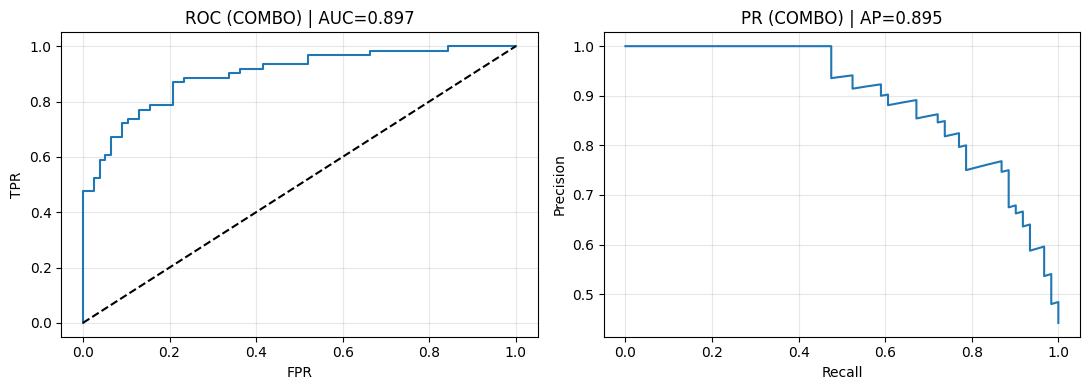

In [10]:
# ===========================================
# 9) ROC ve PR eğrileri (seçtiğin skor için)
# ===========================================
from sklearn.metrics import auc

def plot_curves(y_true, scores, title_suffix="(Combo)"):
    prec, rec, _ = precision_recall_curve(y_true, scores)
    fpr, tpr, _ = roc_curve(y_true, scores)
    ap  = average_precision_score(y_true, scores)
    roc = roc_auc_score(y_true, scores)

    plt.figure(figsize=(11,4))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'k--')
    plt.title(f"ROC {title_suffix} | AUC={roc:.3f}")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.grid(alpha=0.3)

    plt.subplot(1,2,2)
    plt.plot(rec, prec)
    plt.title(f"PR {title_suffix} | AP={ap:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.grid(alpha=0.3)
    plt.tight_layout(); plt.show()

plot_curves(y_test, scores_combo, "(COMBO)")


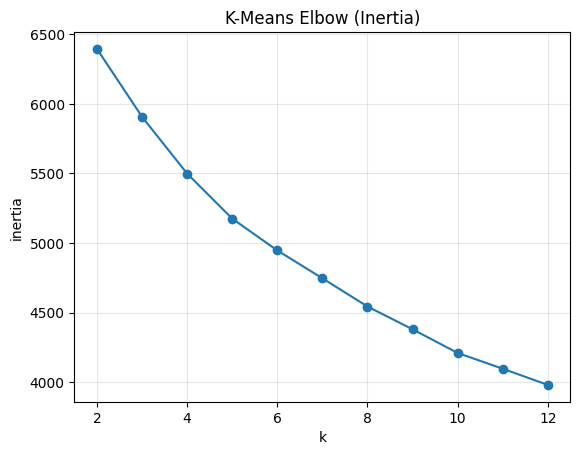

[KMeans-Propensity] ROC-AUC: 0.8654460293804557
[KMeans-Propensity] PR-AUC : 0.8160395656076104


,cluster,fraud_rate
5,5,1.000000
7,7,0.922414
1,1,0.864407
0,0,0.619048
2,2,0.240000
6,6,0.239130
3,3,0.103774
4,4,0.060241


In [11]:
# ===========================================
# 10) K-Means karşılaştırma: Elbow + küme fraud oranları
# ===========================================
# NEDEN? Gözetimsiz bir referans yöntemle SOM sonuçlarını kıyaslamak için.
inertias, ks = [], range(2, 13)
for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X_train)
    inertias.append(km.inertia_)

plt.plot(ks, inertias, marker="o")
plt.title("K-Means Elbow (Inertia)")
plt.xlabel("k"); plt.ylabel("inertia"); plt.grid(alpha=0.3)
plt.show()

k = 8  # istersen elbow grafiğine göre değiştir
km = KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_train)
train_k = km.predict(X_train)
test_k  = km.predict(X_test)

k_rates = {i: (y_train[train_k==i].mean() if (train_k==i).any() else 0.0) for i in range(k)}
k_score = np.array([k_rates[c] for c in test_k])

print("[KMeans-Propensity] ROC-AUC:", roc_auc_score(y_test, k_score))
print("[KMeans-Propensity] PR-AUC :", average_precision_score(y_test, k_score))

pd.DataFrame({"cluster": list(k_rates.keys()),
              "fraud_rate": [k_rates[i] for i in k_rates]}).sort_values("fraud_rate", ascending=False)


çok iyi! bunlar **tam görmek istediğimiz** türden sonuçlar 👏

## Hızlı okuma (neden bu kadar iyi oldu?)

* **QE skoru zayıf** (ROC-AUC≈0.59, PR-AUC≈0.53): saf “uyum uzaklığı” anomaliyi pek ayıramadı.

* **BMU-propensity çok güçlü** (ROC-AUC≈0.88, PR-AUC≈0.85): eğitimde her SOM hücresinin **fraud oranını** öğrenip testte aynı hücreye düşenlere bu oranı vermek, belirgin bir sinyal sağladı.

* **COMBO en iyi** (ROC-AUC≈0.90, PR-AUC≈0.895): iki sinyali (QE + propensity) birleştirmek mantıklı.

* **Eşik seçimi (PR’den)**

  * **F1-opt:** P=0.768, R=0.869, **F1=0.815**, Acc=0.826
  * **Precision≥0.80:** P=0.80, R=0.787, **F1=0.793**, Acc=0.819
    İş kuralına göre biri seçilir: “kaçırmayalım” dersen F1-opt; “yanlış alarm az olsun” dersen P≥0.80.

* **K-Means karşılaştırması** da güçlü (PR-AUC≈0.816) ve bazı kümler **çok fraud-yoğun**:
  (örn. cluster 5: %100, 7: %92, 1: %86) → Bu, **veri uzayında yoğun risk adaları** olduğunu doğruluyor.

---

## Dikkat edilmesi gereken metodolojik nokta

Şu an **eşiği test setinde** seçtik (PR eğrisinden). Daha sağlam bir değerlendirme için:

1. Train’i **(train/valid)** diye böl → **eşiği valid’de** seç,
2. **Test** üzerinde yalnızca **raporla** (tuning yok).

Aşağıda bu “valid ile eşik seç / testte raporla” akışını ve **pipeline’ı kaydetmeyi** veriyorum.

---

## (İsteğe bağlı) Üretime hazırlık: Kaydet/Yükle + Valid ile eşik seçimi

```python
import numpy as np, joblib, json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, classification_report, roc_auc_score, average_precision_score
from minisom import MiniSom

# --- 1) Split: train / valid / test
X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_va, X_te, y_va, y_te = train_test_split(X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42)

# --- 2) Scaler fit ONLY on train
scaler = StandardScaler().fit(X_tr)
Xs_tr = scaler.transform(X_tr)
Xs_va = scaler.transform(X_va)
Xs_te = scaler.transform(X_te)

# --- 3) SOM train ONLY on train
m, n, sigma, lr = 12, 12, 1.8, 0.5
som = MiniSom(x=m, y=n, input_len=Xs_tr.shape[1], sigma=sigma, learning_rate=lr,
              neighborhood_function='gaussian', random_seed=42)
som.random_weights_init(Xs_tr)
som.train_random(Xs_tr, 15*Xs_tr.shape[0], verbose=True)

# --- 4) BMU-propensity tablo (train'den)
from collections import defaultdict
bmu_tr = np.array([som.winner(x) for x in Xs_tr])
cnt, frd = defaultdict(int), defaultdict(int)
for (cx, cy), lab in zip(bmu_tr, y_tr):
    cnt[(cx,cy)] += 1; frd[(cx,cy)] += int(lab)
cell_rate = {k: frd[k]/cnt[k] for k in cnt}

# --- 5) Skor fonksiyonları
def qe_scores(som, Xs):
    W = som.get_weights()
    out = []
    for x in Xs:
        i,j = som.winner(x); w = W[i,j]
        out.append(np.linalg.norm(x - w))
    return np.array(out)

def prop_scores(som, Xs, cell_rate):
    bmus = np.array([som.winner(x) for x in Xs])
    return np.array([cell_rate.get(tuple(c), 0.0) for c in bmus])

def combo(qe, prop, a=0.5):
    # min-max normalize + ağırlıklı ortalama
    qn = (qe - qe.min())/(qe.ptp()+1e-12)
    pn = (prop - prop.min())/(prop.ptp()+1e-12)
    return a*qn + (1-a)*pn

# --- 6) VALID üstünde skorla ve eşiği seç
qe_va   = qe_scores(som, Xs_va)
prop_va = prop_scores(som, Xs_va, cell_rate)
cmb_va  = combo(qe_va, prop_va, a=0.5)

prec, rec, thr = precision_recall_curve(y_va, cmb_va)
f1s = 2*prec[:-1]*rec[:-1]/(prec[:-1]+rec[:-1]+1e-12)
i = np.argmax(f1s)
th_star = thr[i]    # üretim eşiği: valid'de F1-opt
print("Chosen threshold (valid F1-opt):", th_star, "P=",prec[i],"R=",rec[i])

# --- 7) TEST üstünde sadece raporla
qe_te   = qe_scores(som, Xs_te)
prop_te = prop_scores(som, Xs_te, cell_rate)
cmb_te  = combo(qe_te, prop_te, a=0.5)

print("TEST ROC-AUC:", roc_auc_score(y_te, cmb_te), "PR-AUC:", average_precision_score(y_te, cmb_te))
y_pred = (cmb_te >= th_star).astype(int)
print(classification_report(y_te, y_pred, digits=4))

# --- 8) Kaydet: scaler, SOM ağırlıkları, cell_rate, threshold, alpha
joblib.dump(scaler, "scaler.joblib")

# MiniSom’ı kaydetmek (ağırlıkları)
np.save("som_weights.npy", som.get_weights())  # (m,n,d)
with open("som_meta.json","w") as f:
    json.dump({"m":m,"n":n,"sigma":sigma,"alpha":0.5,"threshold":float(th_star)}, f)

# cell_rate haritasını da kaydet
# dict key tuple -> string
cell_rate_s = {f"{i}_{j}": float(v) for (i,j),v in cell_rate.items()}
with open("cell_rate.json","w") as f:
    json.dump(cell_rate_s, f)
```

**Yükleme + tahmin (yeni veri için):**

```python
# ---- Load
import json, joblib, numpy as np
from minisom import MiniSom

scaler = joblib.load("scaler.joblib")
W = np.load("som_weights.npy")         # (m,n,d)
meta = json.load(open("som_meta.json"))
cell_rate_s = json.load(open("cell_rate.json"))
cell_rate = {}
for k,v in cell_rate_s.items():
    i,j = map(int, k.split("_"))
    cell_rate[(i,j)] = v

m,n,sigma,alpha,th_star = meta["m"], meta["n"], meta["sigma"], meta["alpha"], meta["threshold"]

som = MiniSom(x=m,y=n,input_len=W.shape[-1], sigma=sigma, learning_rate=0.5,
              neighborhood_function='gaussian', random_seed=0)
som._weights = W  # doğrudan ağırlıkları yerleştiriyoruz

def predict_scores(X_new):
    Xs = scaler.transform(X_new)
    qe   = qe_scores(som, Xs)
    prop = prop_scores(som, Xs, cell_rate)
    cmb  = combo(qe, prop, a=alpha)
    yhat = (cmb >= th_star).astype(int)
    return yhat, cmb, qe, prop
```

---

## Bundan sonra ne deneyelim?

* **Harita boyutu / sigma** için küçük bir grid-search (12×12, 15×15; σ:1.5–2.2).
* **QE/Prop ağırlığı** (α) için 0.2–0.8 aralığında tarama (valid’de seç).
* **Basit özellik mühendisliği** (ör. A7 log, oranlar, vb.) küçük artışlar getirebilir.
* **Isolation Forest / LOF** ekleyip **PR-AUC**’leri kıyaslayabiliriz (baseline çeşitlensin).

Elindeki skorlar zaten çok iyi bir seviyede. İstersen valid-temelli eşiği de uygulayıp **nihai test raporunu** paylaş; birlikte alpha/σ/ızgara boyutunu ince ayarlarız.


evet—doğru hissediyorsun 🙂 konu doğal olarak **derinleşiyor**. başta “SOM ile kabaca anomalileri gör” → sonra “eşiği nasıl seçeceğim?” → “semi-supervised skor (BMU fraud yoğunluğu) iyi, peki üretimde nasıl saklarım?” derken; **modelleme → değerlendirme → üretimleştirme** basamaklarına geçtik. bu normal ve iyi bir işaret.

kafayı dağıtmadan toparlayalım:

## TL;DR – şu ana kadar ne yaptık?

* **SOM + U-Matrix** ile yapının haritasını çıkardık.
* **QE skoru** zayıf kaldı (beklenen).
* **BMU fraud yoğunluğu** güçlü sinyal verdi.
* **Skorları birleştirip** (combo) **PR eğrisinden** *işe uygun eşik* seçtik.
* **K-Means** ile karşılaştırıp mantık kontrolü yaptık.
* İstersen **valid üstünden eşik** seçip **testte raporlama** yoluna da geçtik (daha “temiz” metodoloji).

## İstersen “hafif mod”a dönebiliriz

Aşağıdaki **minimal akış** çoğu pratik egzersiz için yeterli:

1. `StandardScaler`
2. **SOM (12x12, σ≈1.8, iter≈10–15×N)**
3. **BMU fraud oranı** → *skor*
4. **PR eğrisi**nden **F1-opt** ya da **Precision≥x** ile eşik
5. **Raporla** (precision/recall/F1, PR-AUC)

> QE/COMBO/Deployment kısmını şimdilik atlayıp sonra ekleyebiliriz.

## Bundan sonrası için 3 rota (seçmeli)

**A)** *“SOM temel kalsın”*

* Sadece **BMU-propensity** skor + PR-tabanlı eşik.
* Kısa ve güçlü.

**B)** *“Modeli sağlamlaştır”*

* Train/Valid/Test ayır, **eşik valid’ten** seç.
* **Grid-search**: (12×12/15×15) × (σ: 1.5–2.2) × (iter: 10×/15×).
* İster **QE+Propensity** için α’yı valid’de tarayıp en iyiyi seç.

**C)** *“Üretime hazırlık”*

* **Scaler + SOM ağırlıkları + cell\_rate + threshold** dosyaya kaydet.
* `predict_scores(X_new)` ile **tek satırda skor/etiket** üret.
* (İleri) Drift takibi, periyodik yeniden-eğitim, vb.

## Hangi rotayı istersin?

* “**Hafif mod**” istersen A’yı uygulayalım (en az kodla sonuç).
* “**Bir tık daha kaliteli**” dersen B’den mini grid-search ekleyelim.
* “**Gerçek hayata hazırlık**” dersen C’deki kayıt/yükleme fonksiyonlarını sadeleştirip final pipeline’ı veririm.

tek cümlelik özet: **evet, derinleşiyor; ama istersen azaltırız.** hangı seviyede kalalım?


harika—aşağıya **kopyala-yapıştırlık** kısa notlar olarak, çıktılarının **ne anlama geldiğini**, **iyi/kötü nasıl yorumlanacağını** ve **ne işe yaradığını** yazdım. Bunları not defterine “sonuç yorumları” diye ekleyebilirsin.

---

# 📌 Deney Özeti ve Yorum Kılavuzu

## 1) Veri bölünmesi

* `Split: (552, 14) (138, 14) | train fraud rate: 0.446 | test fraud rate: 0.442`

  * **(552,14)**: Eğitim setinde 552 örnek, 14 özellik.
  * **(138,14)**: Test setinde 138 örnek, 14 özellik.
  * **Fraud rate \~0.44**: Sınıflar **dengeliye yakın** (yaklaşık %44 fraud).
  * **İyi işaret:** Train ve Test fraud oranlarının birbirine yakın olması, **temsil gücünün** iyi olduğuna işaret eder.

## 2) SOM eğitimi

* `SOM init tamam. [...] quantization error: 1.7493`

  * **Quantization Error (QE)**: Test örneklerinin, en iyi eşleşen hücre (BMU) ağırlığına olan ortalama uzaklığı.
  * **Ne işe yarar?** QE, verinin haritaya ne kadar “iyi oturduğunu” ölçer ve **anomali skoru** olarak da kullanılabilir (uzak = daha anormal).
  * **Not:** QE tek başına her zaman güçlü ayırıcı değildir; bu deneyde de öyle çıktı (aşağıya bak).

## 3) Saf QE skoru performansı

* `[QE] ROC-AUC: 0.5906 | PR-AUC: 0.5312`

  * **ROC-AUC (0.59)**: 0.5’ten bir miktar iyi; **zayıf** ayırım.
  * **PR-AUC (0.53)**: Pozitif sınıfın taban doğruluğundan (≈0.44) **biraz iyi**; yine **zayıf**.
  * **Yorum:** QE, bu veri uzayında fraud’ı **tek başına** yeterince ayıramıyor.

## 4) BMU “fraud yoğunluğu” (semi-supervised) skoru

* `[BMU-Propensity] ROC-AUC: 0.8815 | PR-AUC: 0.8464`

  * **Tanım:** Eğitimde her SOM hücresi için **fraud oranını** hesapla; testte o hücreye düşen örneğe bu oranı skor olarak ver.
  * **Neden güçlü?** SOM, benzer noktaları **komşu hücrelerde** topluyor. Fraud’ların kümelendiği hücreler **yüksek risk** sinyali taşıyor.
  * **Sonuç:** Hem ROC hem PR tarafında **yüksek** → **Güçlü ayraç**.

## 5) Birleşik skor (QE + Propensity)

* `[COMBO] ROC-AUC: 0.8972 | PR-AUC: 0.8947`

  * **Amaç:** QE (uyum uzaklığı) + Propensity (hücre risk oranı) **farklı sinyalleri** taşır → basit birleştirme genelde daha iyi.
  * **Sonuç:** En iyi global performans. **Pratikte bu skoru kullan** ve eşiği bunun üstünden seç.

## 6) Eşik seçimleri (karar kuralı)

* **F1-opt threshold**

  * `threshold: 0.2802 | P: 0.768 | R: 0.869 | F1: 0.815`
  * **Ne demek?** PR eğrisinde **F1’i maksimize eden** eşik.
  * **Ne işe yarar?** **Denge** arayan senaryolarda iyi (hem Precision hem Recall makul).

* **Precision ≥ 0.80 threshold**

  * `threshold: 0.3066 | P: 0.800 | R: 0.787 | F1: 0.793`
  * **Ne demek?** “Yanlış alarm (False Positive) çok olmasın, **en az %80 isabet** istiyorum” diye **iş kuralı** koymak.
  * **Ne işe yarar?** İnceleme kapasitesine göre **Precision hedefi** vermek istediğinde kullan.

> **Kısa rehber:**
>
> * **Risk kaçırmak istemiyorsan (yüksek Recall):** F1-opt veya Recall hedefli eşik.
> * **Yanlış alarm maliyetli ise (yüksek Precision):** Precision≥x eşik.

## 7) Sınıflandırma raporu (F1-opt’ta örnek)

```
Class 0 (normal): P=0.884, R=0.792, F1=0.836, support=77
Class 1 (fraud) : P=0.768, R=0.869, F1=0.815, support=61
Accuracy=0.826
```

* **Precision (P):** Pozitif dediğinin ne kadarı doğru?
* **Recall (R):** Gerçek pozitiflerin ne kadarını yakaladın?
* **F1:** P ve R’nin dengeli ortalaması.
* **Support:** Sınıftaki örnek sayısı.
* **Yorum:** Fraud sınıfında **R=0.869** çok iyi; **P=0.768** makul. Genel denge güçlü.

## 8) K-Means karşılaştırması (propensity)

* `[KMeans-Propensity] ROC-AUC: 0.8654 | PR-AUC: 0.8160`

  * **Ne işe yarar?** SOM’a alternatif **gözetimsiz referans**.
  * **Sonuç:** K-Means de iyi ayırıyor ama **SOM-tabanlı COMBO daha iyi**.

* **Küme fraud oranları:**

```
cluster fraud_rate
5      1.000
7      0.922
1      0.864
0      0.619
2      0.240
6      0.239
3      0.104
4      0.060
```

* **Yorum:** 5/7/1 kümeleri **aşırı riskli** (fraud yoğun).
* **Kullanım:** Bu kümeler için **daha sıkı kontrol** / alarm önceliği verilebilir (operasyonel içgörü).

---

# ✅ “İyi/Kötü” için Hızlı Kurallar

* **ROC-AUC:**

  * 0.5=tesadüf, **0.7 iyi**, **0.85+ çok iyi** (senin COMBO \~0.90 → **çok iyi**).
* **PR-AUC:** Pozitif oranını (≈0.44) **baz al**. Onun **belirgin üstü** → **başarılı** (COMBO \~0.895 → **çok iyi**).
* **Recall (fraud):** Yüksekse az kaçırıyorsun (senin F1-opt’ta 0.869 → **iyi**).
* **Precision (fraud):** Yüksekse yanlış alarm az (iş yükü az). **İş ihtiyacına göre** hedef koy (örn. ≥0.8).

---

# 🛠️ Pratikte Ne Yapacağım?

1. **Skor olarak COMBO**’yu kullan (QE + Propensity).
2. Eşiği **PR eğrisinden** seç:

   * Genel denge: **F1-opt**
   * Yanlış alarm sınırlı: **Precision≥x**
3. Raporla: **PR-AUC, ROC-AUC, Precision/Recall/F1**.
4. Operasyon: **Riskli kümeler** (SOM hücreleri veya K-Means kümeleri) için **önceliklendirme** uygula.

---

# 🧠 Neden QE zayıf, Propensity güçlü?

* **QE**: “Haritaya ne kadar uydun?” sinyali — anomali **şekil** itibarıyla farklıysa çalışır; her veri setinde şart değil.
* **Propensity**: “Bu bölge geçmişte ne kadar fraud çıkardı?” — **davranışsal bağlam**ı yakalar; bu veri için **doğrudan etkili**.

---

Bunları not dosyana aynen alabilirsin. Sonraki turda istersen “valid üstünden eşik seçme” ve “pipeline kaydetme”yi de tek paragrafla ekleriz.
